In [1]:
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from algorithms.bisection import BisectionLearner
from algorithms.exp_weights import ExpWeights
from algorithms.exp_fast import ExpWeightsFast
from algorithms.ons import ONS
from algorithms.thompson_sampling import ThompsonSamplingLearner
from bandit import BanditProblem
from runner import Runner

np.random.seed(42)

n = 100  # number of basis functions
B = 5.0  # budget on sum of weights
sigma = 0.01  # noise standard deviation
horizon = 100  # number of time steps per trial
num_trials = 3  # number of independent trials

prior_mu = np.random.uniform(0, 1, n)
B_mu = np.random.uniform(0, 1) * B
prior_mu = prior_mu / np.sum(prior_mu) * B_mu
prior_Sigma = np.eye(n) * 1.0

learner_configs = [
    (
        "ThompsonSampling",
        ThompsonSamplingLearner,
        {
            "prior_mu": prior_mu,
            "prior_Sigma": prior_Sigma,
            "B": B,
            "n": n,
            "noise_sigma": sigma,
            "burn_in": 500,
        },
    ),
    (
        "BisectionLearner",
        BisectionLearner,
        {
            "initial_interval": [0, 1],
            "horizon": horizon,
            "delta": 1 / np.sqrt(horizon),
            "sigma": sigma,
            "confidence_const": 1,
        },
    ),
    (
        "ExpWeights",
        ExpWeights,
        {"horizon": horizon},
    ),
    # (
    #     "ExpWeightsFast",
    #     ExpWeightsFast,
    #     {"horizon": horizon},
    # ),
    # (
    #     "ONS",
    #     ONS,
    #     {
    #         "horizon": horizon,
    #         "interval": [-1, 1],
    #         "delta": 1 / np.sqrt(horizon),
    #         "M": 1,
    #         "C": 1,
    #     },
    # ),
]

In [2]:
# Plotting tools
# Plot the true function
x = np.linspace(0, 1, 500)


def phi(x, t):
    """Basis function: |x - t|."""
    return np.abs(x - t)


def f(x, w, n):
    ts = np.linspace(1 / n, 1, n)
    x = np.atleast_1d(x)
    return np.sum(np.array([phi(x, t) for t in ts]).T * w, axis=1)


def plot(f_star, runner, name_of_the_plot):
    sns.set_theme(style="ticks", context="paper", font_scale=1)
    n_learners = len(runner.learners)
    fig, axs = plt.subplots(1, n_learners, figsize=(5 * n_learners, 5), squeeze=False)
    # set the title of the plot
    fig.suptitle(name_of_the_plot)
    axs = axs[0]  # get the row of axes
    # x axis shows the domain of the function
    for ax in axs:
        ax.set_xlim([-0.1, 1])
        ax.set_ylim([-0.1, B])
        ax.set_xlabel("x")
        ax.set_ylabel("f(x)")

    algo_names = list(runner.learners[0].keys())

    colors = [
        "blue",
        "orange",
        "green",
        "red",
        "purple",
        "brown",
        "pink",
        "gray",
        "olive",
        "cyan",
    ]

    for j in range(n_learners):
        ax = axs[j]
        y_true = [f_star(x_i) for x_i in x]
        ax.plot(x, y_true, label="True function", color="black", linewidth=2)

        ts = runner.learners[j]["ThompsonSampling"]
        for i in range(horizon):
            if i % 3 != 0:
                continue
            # plot Thompson Sampling's function estimates
            ws = ts.ws[i]
            xs = np.linspace(0, 1, 500)
            ys = f(xs, ws, n)
            if i == 0:
                ax.plot(
                    xs,
                    ys,
                    alpha=np.exp(0.01 * (i - horizon)),
                    linestyle=":",
                    color="black",
                    label="TS-Sampled Functions",
                )
            else:
                ax.plot(
                    xs,
                    ys,
                    alpha=np.exp(0.01 * (i - horizon)),
                    linestyle=":",
                    color="black",
                )

            for k, alg_name in enumerate(algo_names):
                learner = runner.learners[j][alg_name]
                action = learner.history_x[i]
                if i == 0:
                    ax.scatter(
                        action,
                        f_star(action),
                        color=colors[k],
                        label=alg_name,
                        edgecolor="k",
                        zorder=3,
                    )
                else:
                    ax.scatter(
                        action,
                        f_star(action),
                        color=colors[k],
                        alpha=np.exp(0.01 * (i - horizon)),
                        s=100 * np.exp(0.01 * (i - horizon)),
                        edgecolor="k",
                        zorder=3,
                    )
        ax.legend()

    plt.tight_layout()
    plt.show()

## Execution

In [3]:
from utils import quadratic, absolute_value, linear

# QUADRATIC FUNCTION
m = 0.2
a = 4
quadratic = partial(quadratic, m=m, a=a)

bandit = BanditProblem(w_true=None, ts=None, sigma=sigma, f_star=quadratic)

quadratic_runner = Runner(None, learner_configs, horizon, num_trials, problem=bandit)
quadratic_runner.run()

# ABSOLUTE VALUE FUNCTION
m = 0.2
a = 4
absolute_value = partial(absolute_value, m=m, a=a)

bandit = BanditProblem(w_true=None, ts=None, sigma=sigma, f_star=absolute_value)

absolute_runner = Runner(None, learner_configs, horizon, num_trials, problem=bandit)
absolute_runner.run()

# LINEAR FUNCTION
m = -0.1
a = 2
linear = partial(linear, m=m, a=a)

bandit = BanditProblem(w_true=None, ts=None, sigma=sigma, f_star=linear)

linear_runner = Runner(None, learner_configs, horizon, num_trials, problem=bandit)
linear_runner.run()

Optimal action and value:  (np.float64(0.20020020020020018), np.float64(1.6032048064075818e-07))
Optimal action and value:  Optimal action and value:  (np.float64(0.20020020020020018), np.float64(1.6032048064075818e-07))(np.float64(0.20020020020020018), np.float64(1.6032048064075818e-07))

Trial 3/3, Time step 0/100, Learner ThompsonSampling, Regret: 0.4095998396795194
Trial 3/3, Time step 0/100, Learner BisectionLearner, Regret: 0.009999839679519354
Trial 3/3, Time step 0/100, Learner ExpWeights, Regret: 0.6399998396795196
Trial 1/3, Time step 0/100, Learner ThompsonSampling, Regret: 0.23039983967951935
Trial 1/3, Time step 0/100, Learner BisectionLearner, Regret: 0.009999839679519354
Trial 1/3, Time step 0/100, Learner ExpWeights, Regret: -1.6032048064075818e-07
Trial 2/3, Time step 0/100, Learner ThompsonSampling, Regret: 0.24999983967951936
Trial 2/3, Time step 0/100, Learner BisectionLearner, Regret: 0.009999839679519354
Trial 2/3, Time step 0/100, Learner ExpWeights, Regret: 0.03

{'ThompsonSampling': [array([ 0.9 ,  1.86,  2.68,  3.46,  4.24,  4.9 ,  5.5 ,  6.02,  6.48,
          6.86,  7.22,  7.56,  7.9 ,  8.26,  8.58,  8.82,  9.1 ,  9.4 ,
          9.68,  9.98, 10.3 , 10.58, 10.86, 11.14, 11.38, 11.68, 11.96,
         12.24, 12.52, 12.8 , 13.06, 13.34, 13.6 , 13.86, 14.14, 14.38,
         14.62, 14.84, 15.1 , 15.34, 15.56, 15.84, 16.1 , 16.38, 16.66,
         16.9 , 17.16, 17.38, 17.62, 17.88, 18.12, 18.34, 18.6 , 18.84,
         19.06, 19.3 , 19.56, 19.82, 20.06, 20.26, 20.48, 20.7 , 20.92,
         21.12, 21.34, 21.52, 21.76, 21.96, 22.18, 22.4 , 22.62, 22.84,
         23.1 , 23.32, 23.5 , 23.66, 23.86, 24.  , 24.12, 24.3 , 24.44,
         24.64, 24.8 , 24.98, 25.1 , 25.28, 25.44, 25.62, 25.76, 25.94,
         26.12, 26.28, 26.42, 26.56, 26.68, 26.82, 26.98, 27.12, 27.26,
         27.42]),
  array([ 0.96,  1.94,  2.76,  3.48,  4.12,  4.72,  5.28,  5.8 ,  6.26,
          6.66,  7.02,  7.32,  7.62,  7.9 ,  8.16,  8.4 ,  8.64,  8.88,
          9.12,  9.34,  9.

## Plots

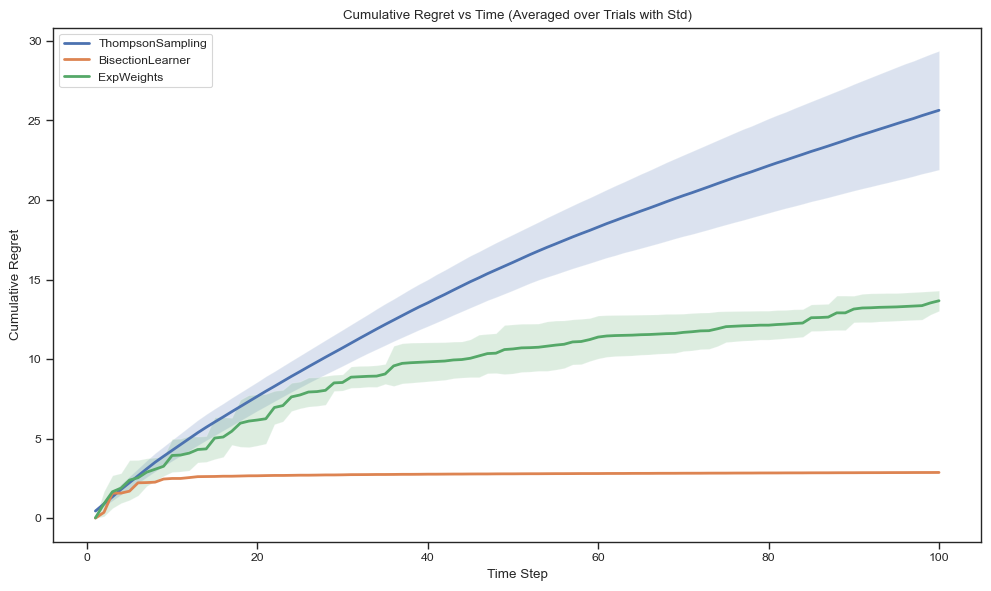

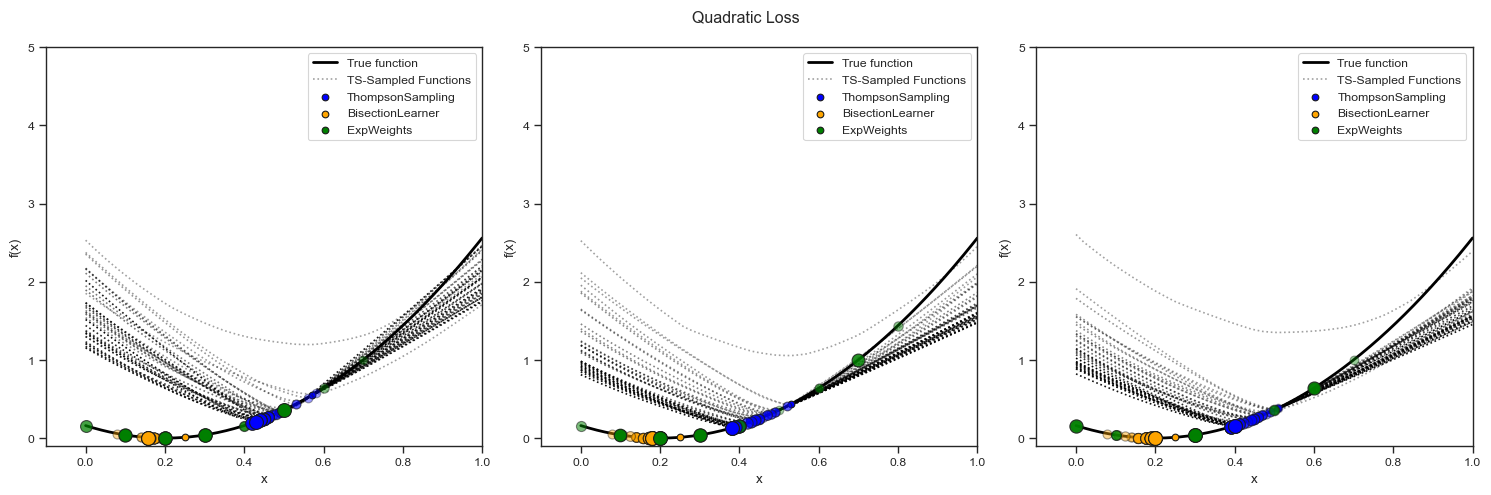

In [70]:
quadratic_runner.plot_regret()
plot(quadratic, quadratic_runner, "Quadratic Loss")

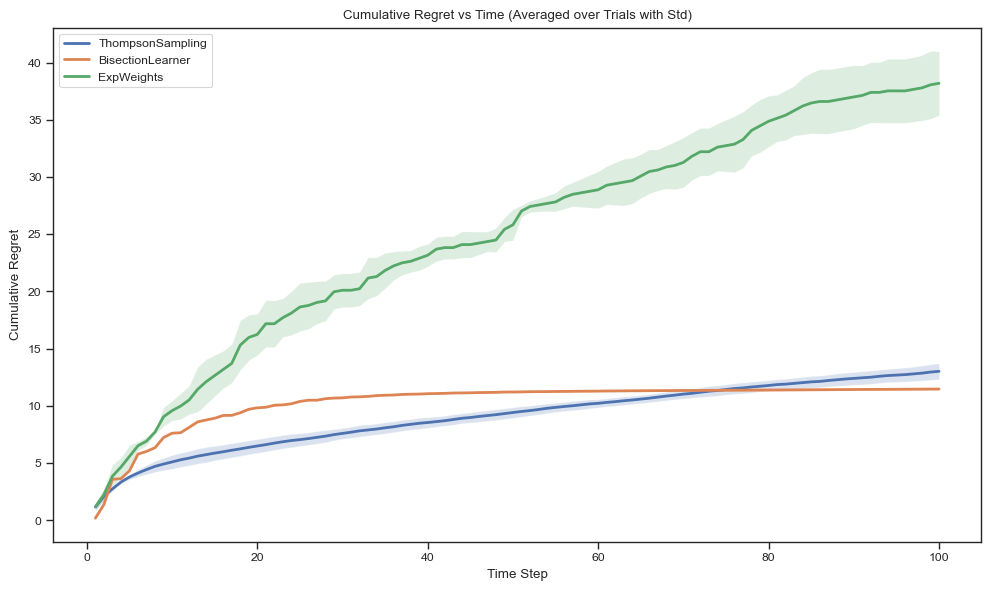

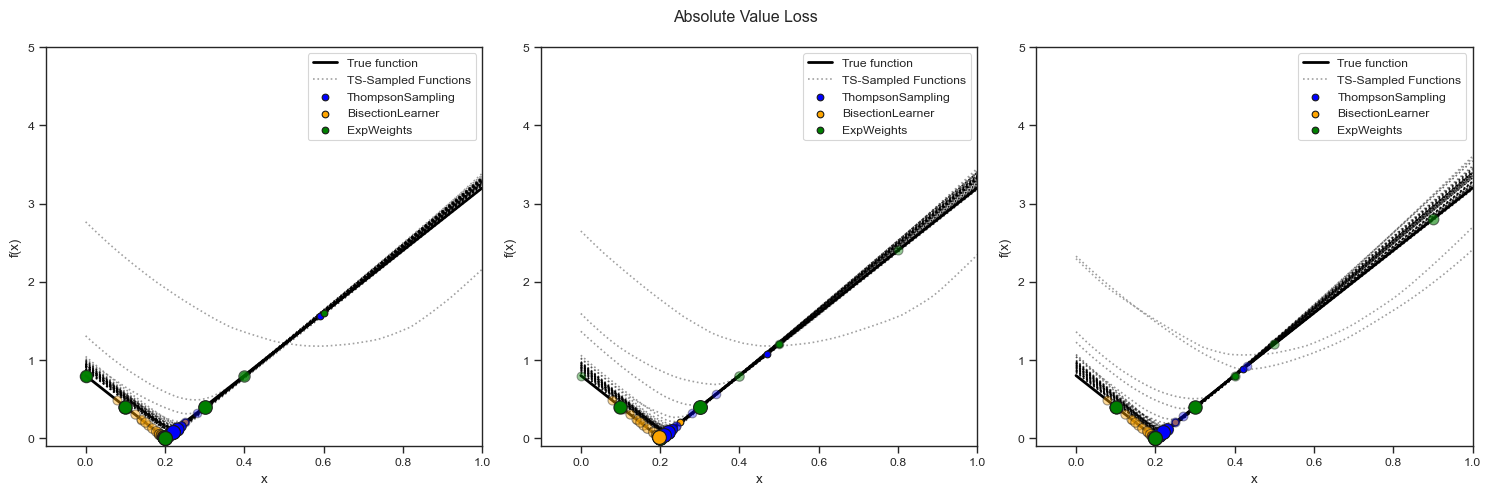

In [71]:
absolute_runner.plot_regret()
plot(absolute_value, absolute_runner, "Absolute Value Loss")

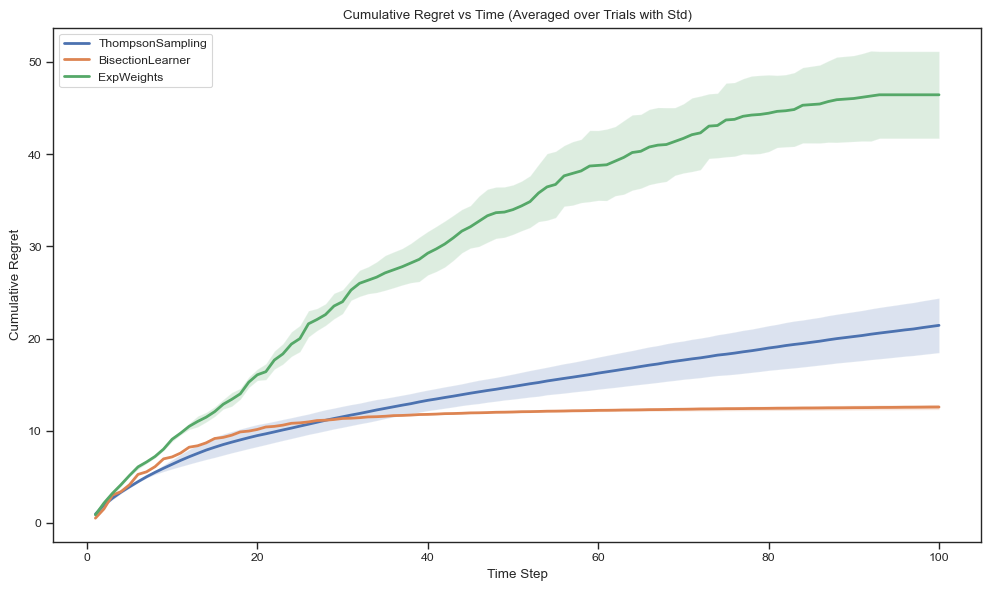

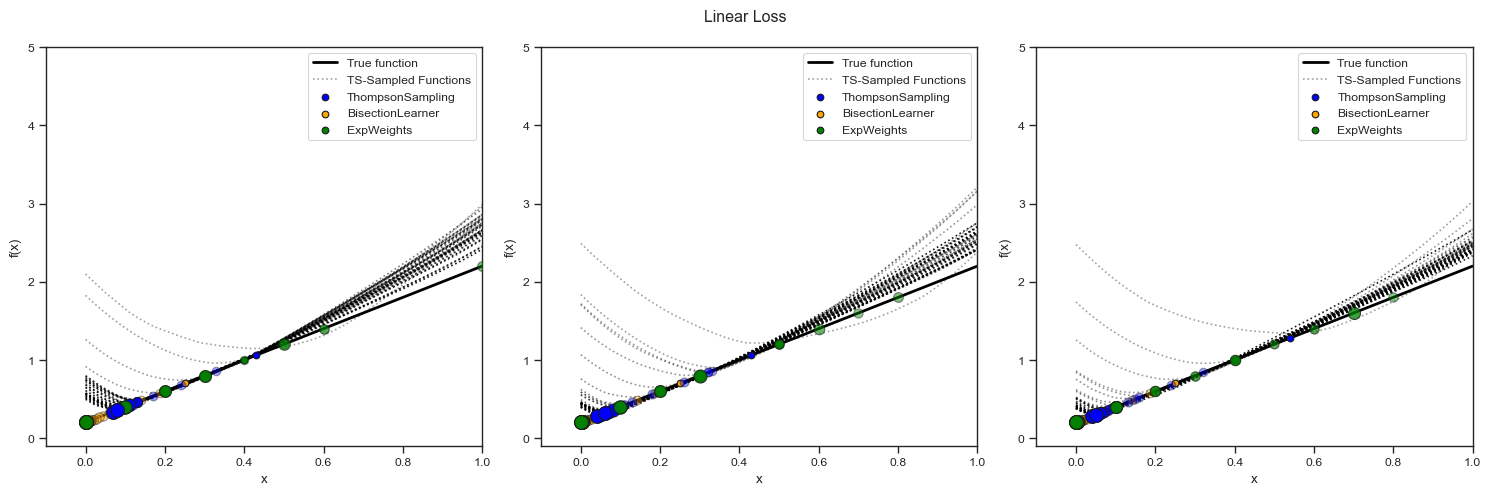

In [72]:
linear_runner.plot_regret()
plot(linear, linear_runner, "Linear Loss")